In [1]:
import pandas as pd
import datetime
import numpy as np
import tensorflow as tf

# グラフ描画
from matplotlib import pylab as plt

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
from oanda_utils import load_assign_dtype

In [3]:
df_m = load_assign_dtype("data/usd_jpy_m1.csv")
df_h = load_assign_dtype("data/usd_jpy_h1.csv")
df_d = load_assign_dtype("data/usd_jpy_d.csv")

In [41]:
target_window = 30
train_mins = 240

x_list = []
y_list = []
cnt = 0

for target_time in df_m['time'][train_mins:-target_window]:

    to_minute = target_time
    to_hour = target_time - datetime.timedelta(minutes = target_time.minute)
    to_date = target_time -  datetime.timedelta(days=1, minutes = target_time.minute, hours = target_time.hour)

    m_cond = (df_m['time']  < to_minute) 
    h_cond =  (df_h['time']  < to_hour) 
    d_cond = (df_d['time'] < to_date)

    df_m_target = df_m[m_cond][-train_mins:]
    df_h_target = df_h[h_cond][-24:]
    df_d_target = df_d[d_cond][-20:]

    df_target = pd.concat([df_d_target, df_h_target, df_m_target])
#     if df_target.shape != (104, 7):
#         cnt += 1
#         print(target_time, df_target.shape, cnt)
#         continue
    x_list.append(df_target[['O', 'H', 'L', 'C']].values[np.newaxis, :, :])
    y_list.append(df_m[~m_cond][:target_window]['C'].values[np.newaxis, :])

In [42]:
X = np.vstack(x_list)
y = np.vstack(y_list)

In [43]:
def standard(arr):
    
    mean =  arr.mean()
    std =  arr.std()
    adj = (arr - mean) / std
    
    return mean, std, adj

In [44]:
mean_open, std_open, X[:, :, 0] = standard(X[:, :, 0])
mean_high, std_high, X[:, :, 1]= standard(X[:, :, 1])
mean_low, std_low, X[:, :, 2] = standard(X[:, :, 2])
mean_close, std_close, X[:, :, 3] = standard(X[:, :, 3])

In [45]:
y = (y - mean_close) / std_close

In [46]:
val_num = 200
test_num = 100

X_train = X[:-(test_num+target_window)][:-val_num]
X_val = X[:-(test_num+target_window)][-val_num:]
X_test = X[-test_num:]

y_train = y[:-(test_num+target_window)][:-val_num]
y_val = y[:-(test_num+target_window)][-val_num:]
y_test = y[-test_num:]

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(509, activation='tanh', input_shape=(None, 4)),
    tf.keras.layers.Dense(target_window)
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError())

In [61]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 509)               1046504   
_________________________________________________________________
dense_6 (Dense)              (None, 30)                15300     
Total params: 1,061,804
Trainable params: 1,061,804
Non-trainable params: 0
_________________________________________________________________


In [62]:
batch_size = 100
n_epoch = 500

# 学習
hist = model.fit(X_train, y_train,
                 epochs=n_epoch,
                 validation_data=(X_val, y_val),
                 verbose=1,
                 batch_size=batch_size)

Epoch 1/500
44/44 [==============================] - 35s 777ms/step - loss: 0.0813 - val_loss: 0.0047
Epoch 2/500
44/44 [==============================] - 35s 801ms/step - loss: 0.0177 - val_loss: 0.0108
Epoch 3/500
44/44 [==============================] - 36s 809ms/step - loss: 0.0176 - val_loss: 0.0035
Epoch 4/500
44/44 [==============================] - 36s 809ms/step - loss: 0.0158 - val_loss: 0.0288
Epoch 5/500
44/44 [==============================] - 36s 809ms/step - loss: 0.0170 - val_loss: 0.0062
Epoch 6/500
44/44 [==============================] - 36s 809ms/step - loss: 0.0164 - val_loss: 0.0262
Epoch 7/500
44/44 [==============================] - 36s 809ms/step - loss: 0.0144 - val_loss: 0.0278
Epoch 8/500
44/44 [==============================] - 36s 810ms/step - loss: 0.0153 - val_loss: 0.0329
Epoch 9/500
44/44 [==============================] - 36s 808ms/step - loss: 0.0133 - val_loss: 0.0277
Epoch 10/500
44/44 [==============================] - 35s 806ms/step - loss: 0.016

44/44 [==============================] - 36s 816ms/step - loss: 0.0031 - val_loss: 0.0249
Epoch 81/500
44/44 [==============================] - 36s 816ms/step - loss: 0.0031 - val_loss: 0.0286
Epoch 82/500
44/44 [==============================] - 36s 816ms/step - loss: 0.0029 - val_loss: 0.0232
Epoch 83/500
44/44 [==============================] - 36s 816ms/step - loss: 0.0026 - val_loss: 0.0259
Epoch 84/500
44/44 [==============================] - 35s 804ms/step - loss: 0.0028 - val_loss: 0.0317
Epoch 85/500
44/44 [==============================] - 35s 807ms/step - loss: 0.0035 - val_loss: 0.0224
Epoch 86/500
44/44 [==============================] - 35s 805ms/step - loss: 0.0027 - val_loss: 0.0253
Epoch 87/500
44/44 [==============================] - 35s 805ms/step - loss: 0.0026 - val_loss: 0.0254
Epoch 88/500
44/44 [==============================] - 35s 806ms/step - loss: 0.0023 - val_loss: 0.0301
Epoch 89/500
44/44 [==============================] - 35s 805ms/step - loss: 0.0022 - 

44/44 [==============================] - 35s 804ms/step - loss: 8.1089e-04 - val_loss: 0.0342
Epoch 159/500
44/44 [==============================] - 35s 805ms/step - loss: 7.9859e-04 - val_loss: 0.0327
Epoch 160/500
44/44 [==============================] - 35s 805ms/step - loss: 7.8511e-04 - val_loss: 0.0332
Epoch 161/500
44/44 [==============================] - 35s 807ms/step - loss: 8.0073e-04 - val_loss: 0.0349
Epoch 162/500
44/44 [==============================] - 35s 805ms/step - loss: 7.7264e-04 - val_loss: 0.0338
Epoch 163/500
44/44 [==============================] - 35s 806ms/step - loss: 7.9977e-04 - val_loss: 0.0321
Epoch 164/500
44/44 [==============================] - 35s 806ms/step - loss: 8.3984e-04 - val_loss: 0.0304
Epoch 165/500
44/44 [==============================] - 35s 806ms/step - loss: 8.1485e-04 - val_loss: 0.0321
Epoch 166/500
44/44 [==============================] - 35s 805ms/step - loss: 7.8895e-04 - val_loss: 0.0347
Epoch 167/500
44/44 [=====================

Epoch 234/500
44/44 [==============================] - 36s 816ms/step - loss: 5.3576e-04 - val_loss: 0.0323
Epoch 235/500
44/44 [==============================] - 36s 815ms/step - loss: 5.1838e-04 - val_loss: 0.0330
Epoch 236/500
44/44 [==============================] - 36s 815ms/step - loss: 4.9242e-04 - val_loss: 0.0313
Epoch 237/500
44/44 [==============================] - 36s 817ms/step - loss: 5.0032e-04 - val_loss: 0.0332
Epoch 238/500
44/44 [==============================] - 36s 816ms/step - loss: 4.7178e-04 - val_loss: 0.0307
Epoch 239/500
44/44 [==============================] - 36s 816ms/step - loss: 4.9166e-04 - val_loss: 0.0298
Epoch 240/500
44/44 [==============================] - 36s 816ms/step - loss: 4.9694e-04 - val_loss: 0.0272
Epoch 241/500
44/44 [==============================] - 36s 817ms/step - loss: 5.0551e-04 - val_loss: 0.0315
Epoch 242/500
44/44 [==============================] - 36s 816ms/step - loss: 4.9054e-04 - val_loss: 0.0343
Epoch 243/500
44/44 [=======

44/44 [==============================] - 36s 818ms/step - loss: 4.3407e-04 - val_loss: 0.0415
Epoch 311/500
44/44 [==============================] - 36s 818ms/step - loss: 4.3501e-04 - val_loss: 0.0418
Epoch 312/500
44/44 [==============================] - 36s 816ms/step - loss: 4.2674e-04 - val_loss: 0.0403
Epoch 313/500
44/44 [==============================] - 36s 817ms/step - loss: 4.1835e-04 - val_loss: 0.0421
Epoch 314/500
44/44 [==============================] - 36s 817ms/step - loss: 4.2375e-04 - val_loss: 0.0413
Epoch 315/500
44/44 [==============================] - 36s 816ms/step - loss: 4.1157e-04 - val_loss: 0.0423
Epoch 316/500
44/44 [==============================] - 36s 816ms/step - loss: 4.0425e-04 - val_loss: 0.0401
Epoch 317/500
44/44 [==============================] - 36s 817ms/step - loss: 4.0331e-04 - val_loss: 0.0429
Epoch 318/500
44/44 [==============================] - 36s 816ms/step - loss: 4.1698e-04 - val_loss: 0.0379
Epoch 319/500
44/44 [=====================

Epoch 386/500
44/44 [==============================] - 36s 817ms/step - loss: 3.4636e-04 - val_loss: 0.0358
Epoch 387/500
44/44 [==============================] - 36s 816ms/step - loss: 3.3437e-04 - val_loss: 0.0351
Epoch 388/500
44/44 [==============================] - 36s 817ms/step - loss: 3.6164e-04 - val_loss: 0.0377
Epoch 389/500
44/44 [==============================] - 36s 817ms/step - loss: 3.8258e-04 - val_loss: 0.0364
Epoch 390/500
44/44 [==============================] - 36s 816ms/step - loss: 3.7644e-04 - val_loss: 0.0337
Epoch 391/500
44/44 [==============================] - 36s 818ms/step - loss: 3.4874e-04 - val_loss: 0.0366
Epoch 392/500
44/44 [==============================] - 36s 817ms/step - loss: 3.3587e-04 - val_loss: 0.0381
Epoch 393/500
44/44 [==============================] - 36s 816ms/step - loss: 3.3281e-04 - val_loss: 0.0349
Epoch 394/500
44/44 [==============================] - 36s 816ms/step - loss: 3.4528e-04 - val_loss: 0.0313
Epoch 395/500
44/44 [=======

Epoch 462/500
44/44 [==============================] - 36s 817ms/step - loss: 2.8667e-04 - val_loss: 0.0355
Epoch 463/500
44/44 [==============================] - 36s 817ms/step - loss: 3.0533e-04 - val_loss: 0.0379
Epoch 464/500
44/44 [==============================] - 36s 816ms/step - loss: 3.0874e-04 - val_loss: 0.0351
Epoch 465/500
44/44 [==============================] - 36s 817ms/step - loss: 2.7413e-04 - val_loss: 0.0319
Epoch 466/500
44/44 [==============================] - 36s 817ms/step - loss: 2.8943e-04 - val_loss: 0.0333
Epoch 467/500
44/44 [==============================] - 36s 817ms/step - loss: 2.7629e-04 - val_loss: 0.0324
Epoch 468/500
44/44 [==============================] - 36s 816ms/step - loss: 2.7107e-04 - val_loss: 0.0353
Epoch 469/500
44/44 [==============================] - 36s 815ms/step - loss: 2.7105e-04 - val_loss: 0.0342
Epoch 470/500
44/44 [==============================] - 36s 817ms/step - loss: 2.6649e-04 - val_loss: 0.0335
Epoch 471/500
44/44 [=======

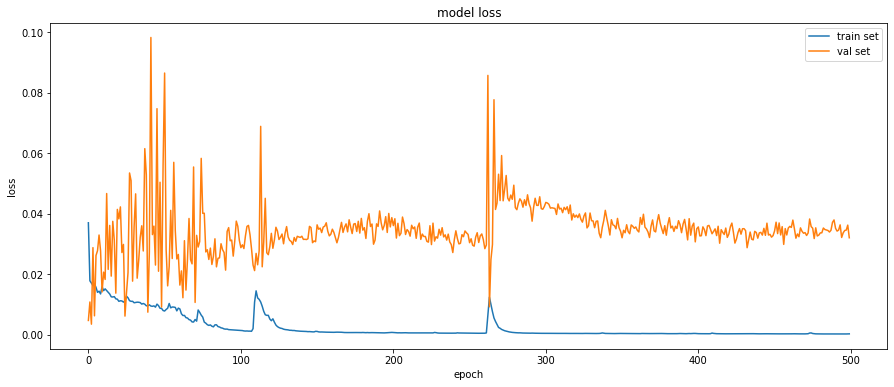

In [63]:
plt.plot(hist.history['loss'],label="train set")
plt.plot(hist.history['val_loss'],label="val set")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.ylim(0, 0.002)
plt.legend()
plt.show()

In [64]:
y_stack  = model.predict(X_test)
y_stack = std_close * y_stack + mean_close
y_raw = std_close * y_test + mean_close

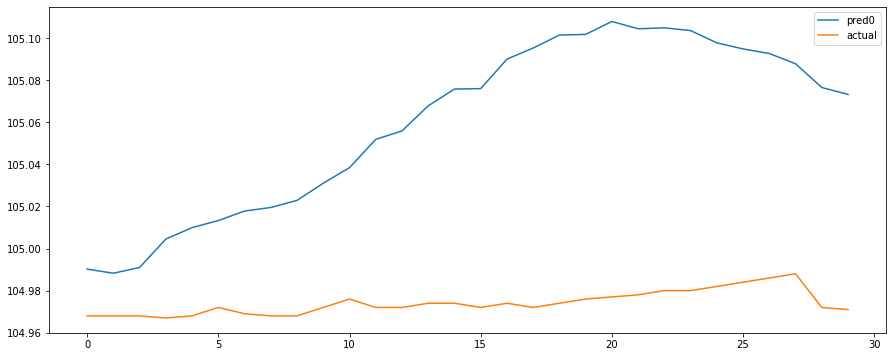

In [67]:
pd.Series(y_stack[10, :]).plot(label='pred0')

pd.Series(y_raw[10, :]).plot(label='actual')
plt.legend()
# plt.xlim(400, 500)
plt.show()

In [68]:
y_raw

array([[104.968, 104.968, 104.966, ..., 104.972, 104.974, 104.976],
       [104.968, 104.966, 104.966, ..., 104.974, 104.976, 104.977],
       [104.966, 104.966, 104.974, ..., 104.976, 104.977, 104.978],
       ...,
       [104.95 , 104.945, 104.938, ..., 104.928, 104.926, 104.929],
       [104.945, 104.938, 104.94 , ..., 104.926, 104.929, 104.928],
       [104.938, 104.94 , 104.944, ..., 104.929, 104.928, 104.926]])